* CNN by TensorFLow
* Low level

In [3]:
import sys
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from tqdm import tqdm

In [4]:
import urllib
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    from six.moves import urllib
    from scipy.io import loadmat
    import os
    print('Could not download MNIST data from mldata.org, trying alternative...')
    mnist_alternative_url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
    mnist_path = './mnist-original.mat'
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, 'wb') as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw['data'].T,
        "target": mnist_raw['label'][0],
        "COL_NAMES": ['label', 'data'],
        "DESCR": 'mldata.org dataset: mnist-original',
    }
    print('Success!')

In [5]:
mnist['data'] = mnist['data'].astype(np.float32).reshape(len(mnist['data']), 28, 28, 1) # image data
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32) # label data
mnist['data'].shape, mnist['target'].shape

((70000, 28, 28, 1), (70000,))

In [6]:
# train data size : validation data size= 8 : 2
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(mnist['data'], mnist['target'], test_size=0.2)

# ラベルはone-hotベクトルに変換する
train_y = np.eye(np.max(train_y)+1)[train_y]
valid_y = np.eye(np.max(valid_y)+1)[valid_y]

train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((56000, 28, 28, 1), (56000, 10), (14000, 28, 28, 1), (14000, 10))

In [7]:
# ネットワークの定義

# プレースホルダー
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y_ = tf.placeholder(tf.float32, shape=(None, 10))

# 畳み込み層1
conv1_features = 20 # 畳み込み層1の出力次元数
max_pool_size1 = 2 # 畳み込み層1のマックスプーリングサイズ
conv1_w = tf.Variable(tf.truncated_normal([5, 5, 1, conv1_features], stddev=0.1), dtype=tf.float32) # 畳み込み層1の重み
conv1_b = tf.Variable(tf.constant(0.1, shape=[conv1_features]), dtype=tf.float32) # 畳み込み層1のバイアス
conv1_c2 = tf.nn.conv2d(x_, conv1_w, strides=[1, 1, 1, 1], padding="SAME") # 畳み込み層1-畳み込み
conv1_relu = tf.nn.relu(conv1_c2+conv1_b) # 畳み込み層1-ReLU
conv1_mp = tf.nn.max_pool(conv1_relu, ksize=[1, max_pool_size1, max_pool_size1, 1], strides=[1, max_pool_size1, max_pool_size1, 1], padding="SAME") # 畳み込み層1-マックスプーリング

# 畳み込み層2
conv2_features = 50 # 畳み込み層2の出力次元数
max_pool_size2 = 2 # 畳み込み層2のマックスプーリングのサイズ
conv2_w = tf.Variable(tf.truncated_normal([5, 5, conv1_features, conv2_features], stddev=0.1), dtype=tf.float32) # 畳み込み層2の重み
conv2_b = tf.Variable(tf.constant(0.1, shape=[conv2_features]), dtype=tf.float32) # 畳み込み層2のバイアス
conv2_c2 = tf.nn.conv2d(conv1_mp, conv2_w, strides=[1, 1, 1, 1], padding="SAME") # 畳み込み層2-畳み込み
conv2_relu = tf.nn.relu(conv2_c2+conv2_b) # 畳み込み層2-ReLU
conv2_mp = tf.nn.max_pool(conv2_relu, ksize=[1, max_pool_size2, max_pool_size2, 1], strides=[1, max_pool_size2, max_pool_size2, 1], padding="SAME") # 畳み込み層2-マックスプーリング

# 全結合層1
result_w = x_.shape[1] // (max_pool_size1*max_pool_size2)
result_h = x_.shape[2] // (max_pool_size1*max_pool_size2)
fc_input_size = result_w * result_h * conv2_features # 畳み込んだ結果、全結合層に入力する次元数
fc_features = 500 # 全結合層の出力次元数（隠れ層の次元数）
s = conv2_mp.get_shape().as_list() # [None, result_w, result_h, conv2_features]
conv_result = tf.reshape(conv2_mp, [-1, s[1]*s[2]*s[3]]) # 畳み込みの結果を1*N層に変換
fc1_w = tf.Variable(tf.truncated_normal([fc_input_size.value, fc_features], stddev=0.1), dtype=tf.float32) # 重み
fc1_b = tf.Variable(tf.constant(0.1, shape=[fc_features]), dtype=tf.float32) # バイアス
fc1 = tf.nn.relu(tf.matmul(conv_result, fc1_w)+fc1_b) # 全結合層1

# 全結合層2
fc2_w = tf.Variable(tf.truncated_normal([fc_features, fc_features], stddev=0.1), dtype=tf.float32) # 重み
fc2_b = tf.Variable(tf.constant(0.1, shape=[fc_features]), dtype=tf.float32) # バイアス
fc2 = tf.nn.relu(tf.matmul(fc1, fc2_w)+fc2_b) # 全結合層2

# 全結合層3
fc3_w = tf.Variable(tf.truncated_normal([fc_features, 10], stddev=0.1), dtype=tf.float32) # 重み
fc3_b = tf.Variable(tf.constant(0.1, shape=[10]), dtype=tf.float32) # バイアス
pred = tf.nn.softmax(tf.matmul(fc2, fc3_w)+fc3_b)
#y = tf.nn.softmax(tf.matmul(x, W) + b)

# クロスエントロピー誤差
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
cross_entropy = -tf.reduce_sum(y_*tf.log(pred))

# 勾配法
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 正解率の計算
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
epoch_num = 5
batch_size = 1000
train_size = len(train_x)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for epoch in tqdm(range(epoch_num), file=sys.stdout):
    perm = np.random.permutation(train_size)
    total_loss = 0
    for i in range(0, train_size, batch_size):
        batch_x = train_x[perm[i:i+batch_size]]
        batch_y = train_y[perm[i:i+batch_size]]
        train_step.run(feed_dict={x_: batch_x, y_: batch_y})
        total_loss += cross_entropy.eval(feed_dict={x_:batch_x, y_: batch_y})
    if (epoch+1)%1 == 0:
        train_accuracy = accuracy.eval(feed_dict={x_: train_x, y_: train_y})
        test_accuracy = accuracy.eval(feed_dict={x_: valid_x, y_: valid_y})
        tqdm.write('epoch:\t{}\tloss:\t{}\taccuracy:\t{}\ttest accuracy:\t{}'.format(epoch+1, total_loss, train_accuracy, test_accuracy))

epoch:	1	loss:	87826.048828125	accuracy:	0.833392858505249	test accuracy:	0.8343571424484253
epoch:	2	loss:	22228.538848876953	accuracy:	0.9141964316368103	test accuracy:	0.9131428599357605
epoch:	3	loss:	13720.878723144531	accuracy:	0.9390714168548584	test accuracy:	0.9347142577171326
epoch:	4	loss:	10438.166870117188	accuracy:	0.9506964087486267	test accuracy:	0.9468571543693542
epoch:	5	loss:	8523.885612487793	accuracy:	0.960107147693634	test accuracy:	0.9558571577072144
100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


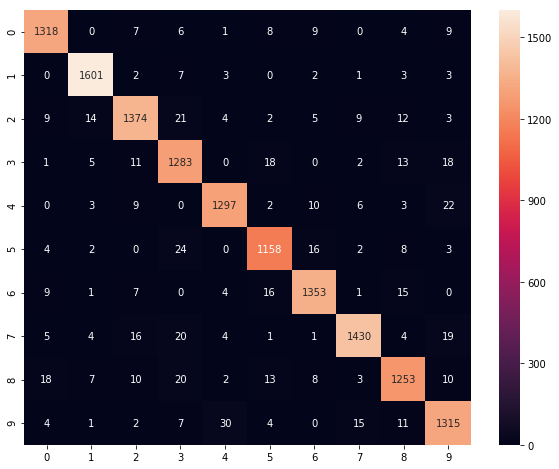

In [9]:
preds = np.argmax(pred.eval(feed_dict={x_: valid_x}), axis=1)

cm = metrics.confusion_matrix(preds, np.argmax(valid_y, axis=1))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

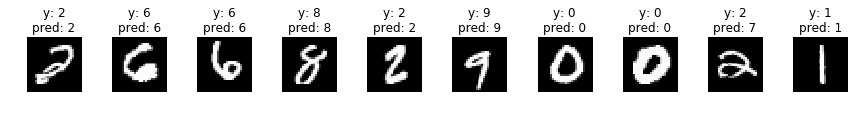

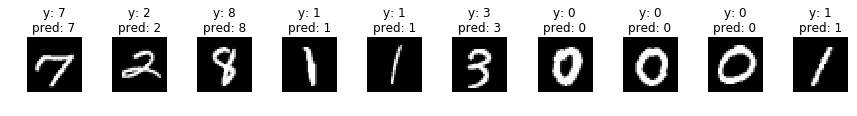

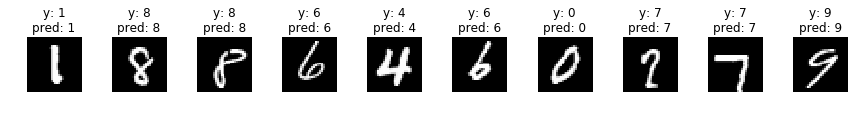

In [10]:
indices = np.random.choice(len(valid_x), 30)

for i, idx in enumerate(indices):
    
    if i%10 == 0:
        fig, axs = plt.subplots(ncols=10, figsize=(15,1))
    
    x = valid_x[idx]
    y = np.argmax(valid_y, axis=1)[idx]
    
    x_img = x.reshape(28, 28)
    x = x[np.newaxis]
    
    p = np.argmax(pred.eval(feed_dict={x_: x}), axis=1)[0]

    axs[i%10].imshow(x_img, cmap='gray')
    title = 'y: {}'.format(y) + '\n' + 'pred: {}'.format(p)
    axs[i%10].set_title(title)
    axs[i%10].axis('off')

plt.show()

In [11]:
!python --version

Python 3.6.3


In [12]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
boto==2.49.0
boto3==1.7.73
botocore==1.10.73
bz2file==0.98
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
docutils==0.14
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
gensim==3.5.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0

In [13]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [14]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
